In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

from typing import List, Optional
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from environment import ManipulatorEnv, State


def animate_plan(env: ManipulatorEnv, plan: List[State], video_output_file: Optional[str] = "solve_4R.mp4"):
    """
    Visualizes the plan with pyplot and, optionally, saves it to the video file.

    :param env: Manipulator environment
    :param plan: Plan - sequence of states
    :param video_output_file: If not None, saves animation to this file. Suggested extension is .mp4.
    """
    video_writer = None
    fig = plt.figure()
    ax = plt.gca()
    ax.set_xlim([-4, 4])
    ax.set_ylim([-2.5, 2.5])
    for i, state in enumerate(plan):
        env.state = state
        env.render(plt_show=False)

        canvas = FigureCanvas(fig)
        canvas.draw()
        mat = np.array(canvas.renderer._renderer)
        mat = cv2.cvtColor(mat, cv2.COLOR_RGB2BGR)
        if video_writer is not None:
            video_writer.write(mat)
        elif video_output_file is not None:
            video_writer = cv2.VideoWriter(video_output_file, cv2.VideoWriter_fourcc(*'mp4v'), 10,
                                           (mat.shape[1], mat.shape[0]))
            video_writer.write(mat)

        if i != len(plan) - 1:
            plt.pause(0.05)
            plt.clf()
        else:
            if video_writer is not None:
                video_writer.release()
            plt.show()


In [2]:
from typing import Union
import numpy as np


def angle_difference(angle1: Union[float, np.ndarray],
                     angle2: Union[float, np.ndarray],
                     directional=False) -> Union[float, np.ndarray]:
    """
    :param angle1: first angle in degrees
    :param angle2: second angle in degrees
    :param return: signed diff between angles (from 0 to 180)
    """
    if type(angle1) is np.ndarray:
        assert type(angle1) == type(angle2)
        assert angle1.shape == angle2.shape
        return np.array([angle_difference(a1, a2) for (a1, a2) in zip(angle1, angle2)])
    delta_angle = angle1 - angle2
    delta_angle = (delta_angle + 180) % 360 - 180
    return delta_angle


def angle_linspace(start_angle: Union[float, np.ndarray],
                   end_angle: Union[float, np.ndarray],
                   n: int):
    """
    :param start_angle: start angle (or whole configuration) in degrees
    :param end_angle: end angle (or whole configuration) in degrees
    :param n: number of steps
    """
    if type(start_angle) is np.ndarray:
        assert type(start_angle) == type(end_angle)
        assert start_angle.shape == end_angle.shape
        return np.array([angle_linspace(a1, a2, n) for (a1, a2) in zip(start_angle, end_angle)]).T

    step = angle_difference(end_angle, start_angle) / n
    result = [start_angle]
    for _ in range(n):
        new_item = result[-1] + step
        if np.abs(new_item) > 180.0:
            if new_item > 0.0:
                new_item = new_item - 360.0
            else:
                new_item = new_item + 360.0
        result.append(new_item)
    return np.array(result)


In [3]:
import numpy as np
import matplotlib.pyplot as plt


class State:

    def __init__(self, angles: np.ndarray):
        """
        Represents the state of the 4-link manipulator.

        :param angles: 4 angles for each link of the manipulator in degrees. Shape: (4,).
        """
        assert angles.shape == (4,)
        assert (np.abs(angles) >= 0.0).all() and (np.abs(angles) <= 180.0).all()
        self._angles = angles.copy()
        self._joints = State._calculate_joint_positions(angles)

    @property
    def angles(self) -> np.ndarray:
        """
        :return: 4 angles for each link of the manipulator in degrees
        """
        return self._angles

    @property
    def joints(self) -> np.ndarray:
        """
        :return: Positions of the 5 joints of the manipulator. Shape: (5, 2).
        """
        return self._joints

    @staticmethod
    def _calculate_joint_positions(angles: np.ndarray) -> np.ndarray:
        seg = np.zeros((5, 2))
        a1, a2, a3, a4 = np.deg2rad(angles)
        T1 = State._se2(np.array([0, 0, a1]))  # this is the first joint, a simple rotation
        T2 = State._se2(
            np.array([1, 0, a2]))  # the second joint, it is a bar of d =1, plus a rotation for the second joint
        T3 = State._se2(np.array([1, 0, a3]))
        T4 = State._se2(np.array([1, 0, a4]))
        T5 = State._se2(
            np.array([1, 0, 0]))  # this is simply to express the lenght of the second bar, no rotation required
        p = T1 @ T2 @ np.array([0, 0, 1])
        seg[1, :] = p[:2]
        p = T1 @ T2 @ T3 @ np.array([0, 0, 1])
        seg[2, :] = p[:2]
        p = T1 @ T2 @ T3 @ T4 @ np.array([0, 0, 1])
        seg[3, :] = p[:2]
        p = T1 @ T2 @ T3 @ T4 @ T5 @ np.array([0, 0, 1])
        seg[4, :] = p[:2]
        return seg

    @staticmethod
    def _se2(q):
        x, y, t = q
        T = np.array([
            [np.cos(t), -np.sin(t), x],
            [np.sin(t), np.cos(t), y],
            [0, 0, 1]])
        return T


class ManipulatorEnv:

    OBSTACLES_DIM = 3  # x, y, radius (assume all obstacles are circles)
    N_LINKS = 4

    def __init__(self,
                 obstacles: np.ndarray,
                 initial_state: State,
                 collision_threshold: float = 0.1):
        assert len(obstacles.shape) == 2 and obstacles.shape[1] == ManipulatorEnv.OBSTACLES_DIM
        self._obstacles = obstacles.copy()
        self._state = initial_state
        self._collision_threshold = collision_threshold

    @property
    def state(self) -> State:
        return self._state

    @state.setter
    def state(self, new_state: State) -> None:
        self._state = new_state

    def check_collision(self, state_to_check: State) -> bool:
        """
        Checks state (configuration) for the collisions.
        :return True if collision, False if no collisions
        """
        for obs in self._obstacles:
            for i in range(ManipulatorEnv.N_LINKS):
                segment = state_to_check.joints[[i, i+1], :]
                r = obs[2] + self._collision_threshold
                p0 = obs[:2]
                p1 = segment[0]
                p2 = segment[1]

                # Check if p1 or p2 in circle
                if np.linalg.norm(p0 - p1) <= r or np.linalg.norm(p0 - p2) <= r:
                    return True

                # Find projection
                t = np.sum((p0 - p1) * (p2 - p1)) / (np.linalg.norm(p2 - p1) ** 2)
                # Check if the projection is on the line
                # (in other words, if line is fully in the circle)
                if t < 0.0 or t > 1.0:
                    continue
                p4 = p1 + t * (p2 - p1)

                if np.linalg.norm(p0 - p4) <= r:
                    return True

        return False

    def render(self, plt_show=True) -> None:
        """
        Displays current configuration.
        :param plt_show: whether to call plt.show() or not
        """
        self._plot_segment(self._state.joints[[0, 1], :], np.array([1, 0, 0]),
                           is_start_link=True)
        self._plot_segment(self._state.joints[[1, 2], :], np.array([0, 1, 0]))
        self._plot_segment(self._state.joints[[2, 3], :], np.array([0, 0, 1]))
        self._plot_segment(self._state.joints[[3, 4], :], np.array([1, 0, 1]),
                           is_end_link=True)
        for obs in self._obstacles:
            plt.gca().add_patch(
                plt.Circle((obs[0], obs[1]), obs[2], fill=True))
        plt.axis('equal')
        if plt_show:
            plt.show()

    @staticmethod
    def _plot_segment(s, color_, is_start_link=False, is_end_link=False):
        plt.plot(s[:, 0], s[:, 1], linewidth=2, color=color_)
        if is_end_link:
            plt.plot(s[1, 0], s[1, 1], marker='>', color=color_)
        else:
            plt.plot(s[1, 0], s[1, 1], marker='o', color=color_)
        if is_start_link:
            plt.plot(s[0, 0], s[0, 1], marker='X', color=color_)
        else:
            plt.plot(s[0, 0], s[0, 1], marker='o', color=color_)


In [4]:
from typing import List, Callable

import numpy as np

from environment import State, ManipulatorEnv
import angle_util

class RRTPlanner:

    def __init__(self,
                 env: ManipulatorEnv,
                 distance_fn: Callable,
                 ret_func: Callable,
                 max_angle_step: float = 10.0):
        """
        :param env: manipulator environment
        :param distance_fn: function distance_fn(state1, state2) -> float
        :param max_angle_step: max allowed step for each joint in degrees
        """
        self._env = env
        self._distance_fn = distance_fn
        self._max_angle_step = max_angle_step

    
    def find_nearest(self,
                     q_rand: State,
                     G: List,
                     ) -> np.array:

        # dist_min = distance_func(np.array([0, 0, 0, 0]), q_rand.angles)
        # nnear = 0
        dist_min = 1000000
        near = []
        # find the nearest sample to the chosen one from the existing graph G:
        for i in G:
            if self._distance_fn(i[1].angles, q_rand.angles) < dist_min:
                dist_min = self._distance_fn(i[1].angles, q_rand.angles)
                near = i[1].angles

        # check if there is a collision (or do it later in the main loop.... have to think of it...)
        return np.array(near)

    
    def steer(self,
              q_rand: State,
              q_near: State,
              ):

        # interpolation, where we have to take into account whether 
        # the rotation of each joint is more than 10 degrees:

        a = []
        T = False

        for i in range(4):
            a.append(angle_util.angle_difference(q_rand.angles[i], q_near.angles[i]))
            if a[i] > self._max_angle_step or a[i] < -self._max_angle_step:
                T = True

        if T == True:
            for i in range(4):
                if a[i] > self._max_angle_step:
                    a[i] = self._max_angle_step
                elif a[i] < -self._max_angle_step:
                    a[i] = -self._max_angle_step

        # later check the linspace and collision
        print("returning the angles:", q_near.angles + a)
        return q_near.angles + a

        '''
        q_curr = q_near.angles.copy()
        s = 0.1
        for i in range(4):
            q_curr[i] += angle_difference(q_rand.agles[i], q_near.agles[i]) * s

        if distance_func(q_curr, q_rand.angles) < distance_func(q_near.angles, q_rand.angles):
            return q_curr, distance_func(q_curr, q_rand.angles)
        else: 
            return q_near.angles, distance_func(q_near.angles, q_rand.angles)
        '''
    

    def plan(self,
             start_state: State,
             goal_state: State,
             samples: List,
             N: int,
             ): #->List[State]:

        # TODO: Implement

        # G[(q_near, q_new)]
        # G[(start_state, q_new)]
        G = [(start_state, start_state)]

        for i in range(N):
            q_rand = State(samples[i])

            # FIND THE NEAREST FOR THE RANDOM IN THE GRAPH G!!111
            q_near = State(self.find_nearest(q_rand, G))

            # define a steer function
            # steer function defines the action, trying to reach the q_new
            # it should include angle difference and linspace, I suppose

            # put constraints (dynamics) here:
            q_new = State(self.steer(q_near, q_rand))  # q_new has to be in between the q_rand and q_near

            # checking for collisions has to be not only for 1 state, but for all
            # linspaces, so I think it's correct to add this check into the 
            # linspace function or combine them somehow into another function
            '''
            if ManipulatorEnv.collision_check(q_new) == False: 
                G.append((q_near, q_new)) # state will be just an object, not a vector
            if q_new.angles == goal_state:
                return G
            '''
            G.append((q_near, q_new))
            if (q_new.angles == goal_state.angles).all():
                print("Good", G)
                return 1
        print("Bad", G)
        return 2


In [5]:
import numpy as np
import pickle
from environment import State, ManipulatorEnv
from rrt import RRTPlanner
from video_util import animate_plan


# You are free to change any interfaces for your needs.


def main():
    with open("data.pickle", "rb") as handle:
        data = pickle.load(handle)

    start_state = State(np.array(data["start_state"]))
    goal_state = State(np.array(data["goal_state"]))
    env = ManipulatorEnv(obstacles=np.array(data["obstacles"]),
                         initial_state=start_state,
                         collision_threshold=data["collision_threshold"])
    
    #planner = RRTPlanner(env)

    #plan = planner.plan(start_state, goal_state)
    #print("RRT planner has finished successfully")

    #animate_plan(env, plan)

# Task 1: Visualization

# Subtask A

Visualize the manipulator in the start state and target state. Comment on your thoughts about
comparison the discretized orientation space from PS1 vs continuous orientation space in current problem
set.

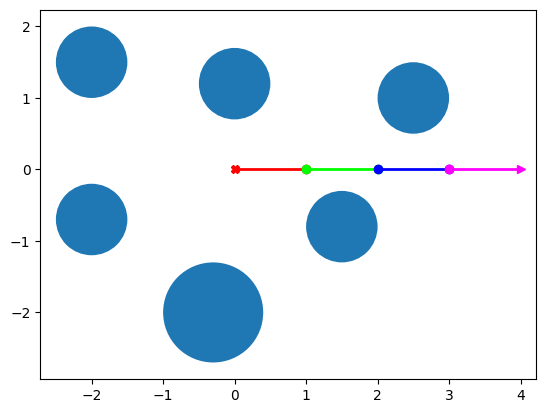

In [6]:
def main():
    with open("data.pickle", "rb") as handle:
        data = pickle.load(handle)

    start_state = State(np.array(data["start_state"]))
    goal_state = State(np.array(data["goal_state"]))
    env = ManipulatorEnv(obstacles=np.array(data["obstacles"]),
                         initial_state=start_state,
                         collision_threshold=data["collision_threshold"])

    env.render()
if __name__ == '__main__':
    main()

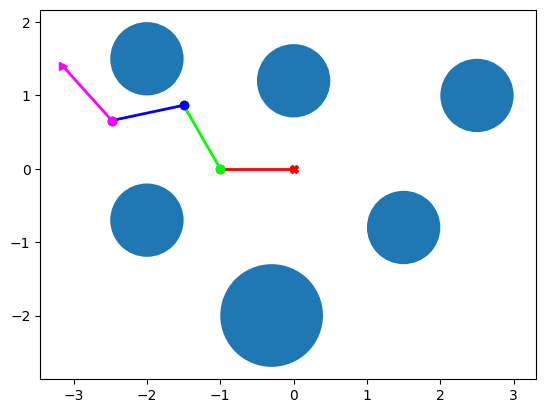

In [7]:
def main():
    with open("data.pickle", "rb") as handle:
        data = pickle.load(handle)

    start_state = State(np.array(data["start_state"]))
    goal_state = State(np.array(data["goal_state"]))
    env = ManipulatorEnv(obstacles=np.array(data["obstacles"]),
                         initial_state=goal_state,
                         collision_threshold=data["collision_threshold"])

    env.render()
if __name__ == '__main__':
    main()

Continuous orientation space in the current Problem set allows to represent such a complex rigid object with several joints, while in the discretized orientation space it would be impossible.

## Subtask B

Visualize the manipulator in 4 random orientations that include both colliding and non-colliding
configurations. Check what does the ManipulatorEnv.check_collision function returns for those
configurations. Comment on your observations.

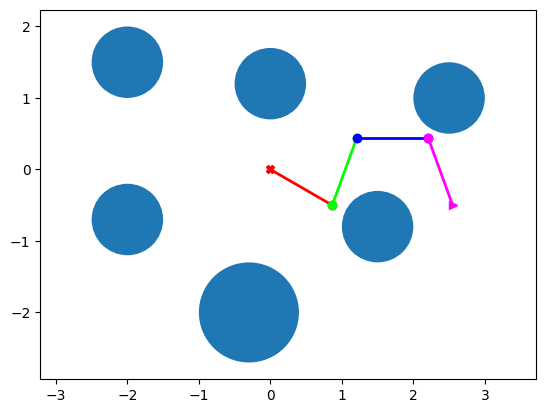

Is here a collision? The answer is: False


In [8]:
def main():
    with open("data.pickle", "rb") as handle:
        data = pickle.load(handle)
        
    #current_state = State(np.array([-72.0, -60.0, 50.0, 150.0]))
    current_state = State(np.array([-30.0, 100.0, -70.0, -70.0]))
    start_state = State(np.array(data["start_state"]))
    goal_state = State(np.array(data["goal_state"]))
    env = ManipulatorEnv(obstacles=np.array(data["obstacles"]),
                         initial_state=current_state,
                         collision_threshold=data["collision_threshold"])


    env.render()
    print("Is here a collision? The answer is:", env.check_collision(current_state))
if __name__ == '__main__':
    main()

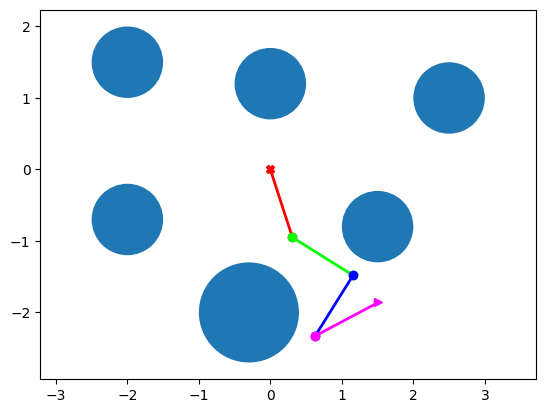

Is here a collision? The answer is: False


In [9]:
def main():
    with open("data.pickle", "rb") as handle:
        data = pickle.load(handle)
        
    current_state = State(np.array([-72.0, 40.0, -90.0, 150.0]))
    
    start_state = State(np.array(data["start_state"]))
    goal_state = State(np.array(data["goal_state"]))
    env = ManipulatorEnv(obstacles=np.array(data["obstacles"]),
                         initial_state=current_state,
                         collision_threshold=data["collision_threshold"])


    env.render()
    print("Is here a collision? The answer is:", env.check_collision(current_state))
if __name__ == '__main__':
    main()

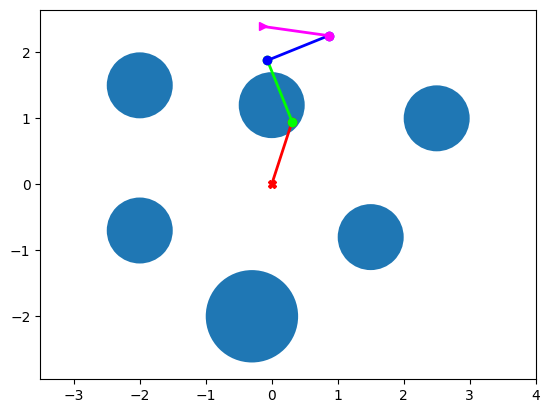

Is here a collision? The answer is: True


In [10]:
def main():
    with open("data.pickle", "rb") as handle:
        data = pickle.load(handle)
        
    current_state = State(np.array([72.0, 40.0, -90.0, 150.0]))
    
    start_state = State(np.array(data["start_state"]))
    goal_state = State(np.array(data["goal_state"]))
    env = ManipulatorEnv(obstacles=np.array(data["obstacles"]),
                         initial_state=current_state,
                         collision_threshold=data["collision_threshold"])


    env.render()
    print("Is here a collision? The answer is:", env.check_collision(current_state))
if __name__ == '__main__':
    main()

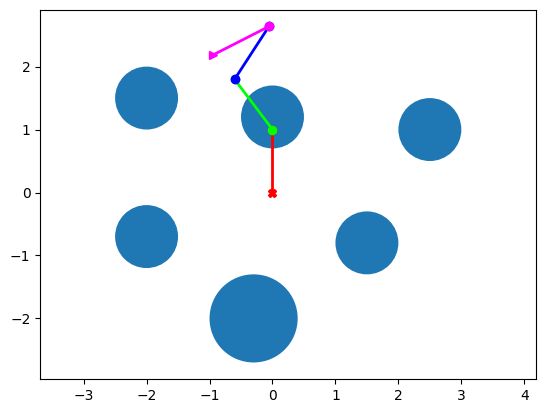

Is here a collision? The answer is: True


In [11]:
def main():
    with open("data.pickle", "rb") as handle:
        data = pickle.load(handle)
        
    current_state = State(np.array([90.0, 37.0, -70.0, 150.0]))
    
    #current_state = State(np.array([-63.80230484, 164.25269815,  45.46296717,  10.52611594]))

    start_state = State(np.array(data["start_state"]))
    goal_state = State(np.array(data["goal_state"]))
    env = ManipulatorEnv(obstacles=np.array(data["obstacles"]),
                         initial_state=current_state,
                         collision_threshold=data["collision_threshold"])

    env.render()
    print("Is here a collision? The answer is:", env.check_collision(current_state))
    
if __name__ == '__main__':
    main()

Obviously, the collision check returns 'True', if there is a collision between an obstacle and one of the rods of the manipulator. On the last plot visually there is no collision (there are several pixels between the manipulator and the circle), but it considers as it is, because there is a circle of a particular radius, that is assumed as an obstacle. This is a forced inaccuracy for solving the task.

# Task 2

## Subtask A

You need to implement the RRT algorithm for agent in continuous domain. The starting configuration of the agent is $(0, 0, 0, 0)$ and the goal configuration is $(-180.0, -60.0, 72.0, -60.0)$.\
For searching nearest pose use $L_1$ distance between two configuration vectors:
$$distance = \|q_2 - q_1 \|_1$$
You may want to use function angle_difference and angle_linspace from **angle_utils.py**. As a
maximum allowed rotation for each joint we suggest you to use 10 degrees.


Save the result of calculated plan in **solve_4R.mp4** (or other video extension) using provided function. If
you want to add more smoothness to the video, you can add additional intermediate configurations, but it’s
optional

You may want to use the function **ManipulatorEnv.check_collision**, in order to check if the the manipulator is in collision at any point towards the new configuration.

*Hint*: you may want to use the collision check function over a small sequence of configurations, connecting
your current one with the new configuration candiate $q_{new}$.

In [12]:
from typing import List, Callable

import numpy as np

from environment import State, ManipulatorEnv
import angle_util

class RRTPlanner:

    def __init__(self,
                 env: ManipulatorEnv,
                 distance_fn: Callable,
                 max_angle_step: float = 10.0):
        """
        :param env: manipulator environment
        :param distance_fn: function distance_fn(state1, state2) -> float
        :param max_angle_step: max allowed step for each joint in degrees
        """
        self._env = env
        self._distance_fn = distance_fn
        self._max_angle_step = max_angle_step

    
    def find_nearest(self,
                     q_rand: State,
                     G: List,
                     ) -> np.array:

        # dist_min = distance_func(np.array([0, 0, 0, 0]), q_rand.angles)
        # nnear = 0
        dist_min = 1000000
        near = []
        # find the nearest sample to the chosen one from the existing graph G:
        for i in G:
            if self._distance_fn(i[1], q_rand.angles) < dist_min: #i[1] - child here
                dist_min = self._distance_fn(i[1], q_rand.angles)
                near = i[1]       

        # check if there is a collision (or do it later in the main loop.... have to think about it...)
        return np.array(near)

    
    def steer(self,
              q_rand: State,
              q_near: State,
              ):

        # interpolation, where we have to take into account whether 
        # the rotation of each joint is more than 10 degrees:
        
        '''
        a = []
        T = False

        for i in range(4):
            a.append(angle_util.angle_difference(q_rand.angles[i], q_near.angles[i]))
            if a[i] > self._max_angle_step or a[i] < -self._max_angle_step:
                T = True

        if T == True:
            for i in range(4):
                if a[i] > self._max_angle_step:
                    a[i] = min(self._max_angle_step, 180 - q_near.angles[i])
                elif a[i] < -self._max_angle_step:
                    a[i] = max(-self._max_angle_step, -180 - q_near.angles[i])
        
        '''
        
        
        # steer(q_near, q_rand) = q_near + (q_rand - q_near) * s:
        
        s = 0.01
        T = False
        a = []
        for i in range(4):
            
            if angle_difference(q_rand.angles[i], q_near.angles[i]) > self._max_angle_step:
                a.append(self._max_angle_step)
            elif angle_difference(q_rand.angles[i], q_near.angles[i]) < -self._max_angle_step:
                a.append(-self._max_angle_step)
            else:
                a.append(angle_difference(q_rand.angles[i], q_near.angles[i]) * s)
            
            if q_near.angles[i] + a[i] > 180:
                if len(a) == i+1:
                    a[i] = 180 - q_near.angles[i]
                else:
                    a.appned(180 - q_near.angles[i])
            elif q_near.angles[i] + a[i] < -180:
                if len(a) == i+1:
                    a[i] = -180 - q_near.angles[i]
                else:
                    a.appned(-180 - q_near.angles[i])
            #print("a:", a)
            #print("q_rand:", q_rand.angles)
            #print("q_near:", q_near.angles)
        
        
        #print("testing the thing:", angle_difference(q_rand.angles[i], q_near.angles[i]) * 0.1)
        #print(q_near.angles + a)
        
        # later check the linspace and collision
        #print(q_near.angles + a)
        return q_near.angles + a

        '''
        q_curr = q_near.angles.copy()
        s = 0.1
        for i in range(4):
            q_curr[i] += angle_difference(q_rand.agles[i], q_near.agles[i]) * s

        if distance_func(q_curr, q_rand.angles) < distance_func(q_near.angles, q_rand.angles):
            return q_curr, distance_func(q_curr, q_rand.angles)
        else: 
            return q_near.angles, distance_func(q_near.angles, q_rand.angles)
        '''
    
    
    def check_reach(
            self,
            q_new: State,
            start_state: State,
            goal_state: State,
            env: ManipulatorEnv,
            ):
        a = angle_difference(q_new.angles, goal_state.angles)
        if (a > -10).all() and (a < 10).all():
            if env.check_collision(q_new) == False:
                return True, q_new
            
        else:
            b = int(max(abs(a // 10)))
            c = []
            result = angle_linspace(np.array(q_new.angles), np.array(goal_state.angles), b)
            
            #print("THE RESULT:", result)
            
            for i in result:
                if env.check_collision(State(i)) == False:
                    c.append(State(i))
            if len(c) == len(result):
                return True, c
            
        return False, q_new

    '''
    def returning(
        self,
        X_I,
        X_G, 
        dictionary,
             ):
        
        a = X_G
        b = 0
        s = [a]
        k = True
        while b != X_I:
            if k:
                b = a
                k = False
            b = dictionary[b][0]
            s.append(b)
        return s
        '''

    def returning(
        self,
        start_state: State,
        goal_state: State,
        G: List,
    ):
        print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        s = []
        d = {}
        for i in G:
            d[i[1]] = i[0]
        print(G[:10])
        print(d.items())
        all_keys = list(d.keys())
        all_values = list(d.values())
        a = all_keys[-1] # child
        b = all_values[-1] # parent
        c = [a]

        while a != goal_state:
            a = b
            b = d[b]
            c.append(a)
        return c
                
                
    
    def plan(self,
             start_state: State,
             goal_state: State,
             samples: List,
             N: int,
             env: ManipulatorEnv,
             ): #->List[State]:

        # TODO: Implement

        # G[(q_near, q_new)]
        # G[(start_state, q_new)]
        G = [(start_state, start_state)]

        for i in range(N):
            q_rand = State(samples[i])

            # FIND THE NEAREST FOR THE RANDOM IN THE GRAPH G!!111
            q_near = State(self.find_nearest(q_rand, G))

            # define a steer function
            # steer function defines the action, trying to reach the q_new
            # it should include angle difference and linspace, I suppose

            # put constraints (dynamics) here:
            q_new = State(self.steer(q_rand, q_near))  # q_new has to be in between the q_rand and q_near

            # checking for collisions has to be not only for 1 state, but for all
            # linspaces, so I think it's correct to add this check into the 
            # linspace function or combine them somehow into another function
            
            if env.check_collision(q_new) == False: 
                G.append((q_near, q_new)) # state will be just an object, not a vector
                
            T = False
            T, curr_item = self.check_reach(q_new, start_state, goal_state, env)
            if T == True:
                #print(type(curr_item) != list)
                if type(curr_item) != list:
                    G.append((q_new, goal_state))
                else:
                    for i in range(1, len(curr_item)):
                        G.append((curr_item[i-1], curr_item[i]))
                print("GOOD")
                print(G)
                #for i in G:
                    #print("Start state:", i[0].angles)
                    #print("Finish state:", i[1].angles)
                #return self.returning(start_state, goal_state, G)
                return 1
            
            '''
            if q_new.angles == goal_state:
                return G
            
            if np.all(q_new.angles == goal_state.angles):
                print("Good")
                return 1
            '''
            
        print("Bad")
        return 2



def sampling(N):
    return np.random.uniform(low=-180.0, high=180.0, size=(N, 4))


def distance_func(vec_1, vec_2):
    return np.linalg.norm(vec_1 - vec_2, ord=1)


'''
def check_reach(self,
            q_new: State,
            goal_state: State,
            env: ManipulatorEnv,
            ):
        
    a = angle_difference(q_new.angles, goal_state.angles)
        
    if np.all(a) > -10 and np.all(a) < 10:
        if env.check_collision(q_new) == False:
            return True, q_new
            
    else:
        b = np.round(np.all(a) // 10)
        c = []
        result = angle_linspace(q_new.angles, goal_state.angles, b+1)
            
        print("THE RESULT:", result)
            
        for i in result:
            if env.check_collision(i) == False:
                c.append(i)
        if len(c) == len(result):
            return True, c
            
    return False, q_new
'''


def main():
    with open("data.pickle", "rb") as handle:
        data = pickle.load(handle)
    print(data)
    start_state = State(np.array(data["start_state"]))
    goal_state = State(np.array(data["goal_state"]))
    env = ManipulatorEnv(obstacles=np.array(data["obstacles"]),
                         initial_state=start_state,
                         collision_threshold=data["collision_threshold"])
    N = 2500
    samples = sampling(N)
    #b = np.array([goal_state.angles])
    #samples = np.concatenate((samples, b), axis=0)

    
    if goal_state.angles in samples:
        print("a")
    else:
        print("no")
    
    #verdict, planner = RRTPlanner(env, distance_func)
    planner = RRTPlanner(env, distance_func)
    
    plan = planner.plan(start_state, goal_state, samples, N, env)
    
    #print(verdict, '\n')
    #print(plan)
    #print("RRT planner has finished successfully")

    #animate_plan(env, plan)

if __name__ == '__main__':
    main()

{'start_state': [0.0, 0.0, 0.0, 0.0], 'goal_state': [-180.0, -60.0, 72.0, -60.0], 'obstacles': [[2.5, 1.0, 0.5], [1.5, -0.8, 0.5], [-2, -0.7, 0.5], [-2, 1.5, 0.5], [0.0, 1.2, 0.5], [-0.3, -2.0, 0.7]], 'collision_threshold': 0.1}
no


TypeError: unsupported operand type(s) for -: 'State' and 'float'

In [ ]:
from typing import List, Callable

import numpy as np

from environment import State, ManipulatorEnv
import angle_util

class RRTPlanner:

    def __init__(self,
                 env: ManipulatorEnv,
                 distance_fn: Callable,
                 max_angle_step: float = 10.0):
        """
        :param env: manipulator environment
        :param distance_fn: function distance_fn(state1, state2) -> float
        :param max_angle_step: max allowed step for each joint in degrees
        """
        self._env = env
        self._distance_fn = distance_fn
        self._max_angle_step = max_angle_step

    
    def find_nearest(self,
                     q_rand: State,
                     G: dict,
                     ) -> np.array:

        # dist_min = distance_func(np.array([0, 0, 0, 0]), q_rand.angles)
        # nnear = 0
        dist_min = 1000000
        near = []
        # find the nearest sample to the chosen one from the existing graph G:
        for i in G:
            if self._distance_fn(i.angles, q_rand.angles) < dist_min:
                dist_min = self._distance_fn(i.angles, q_rand.angles)
                near = i # State
        # check if there is a collision (or do it later in the main loop.... have to think about it...)
        return near

    
    def steer(self,
              q_rand: State,
              q_near: State,
              ):

        # interpolation, where we have to take into account whether 
        # the rotation of each joint is more than 10 degrees:
        
        '''
        a = []
        T = False

        for i in range(4):
            a.append(angle_util.angle_difference(q_rand.angles[i], q_near.angles[i]))
            if a[i] > self._max_angle_step or a[i] < -self._max_angle_step:
                T = True

        if T == True:
            for i in range(4):
                if a[i] > self._max_angle_step:
                    a[i] = min(self._max_angle_step, 180 - q_near.angles[i])
                elif a[i] < -self._max_angle_step:
                    a[i] = max(-self._max_angle_step, -180 - q_near.angles[i])
        
        '''
        
        
        # steer(q_near, q_rand) = q_near + (q_rand - q_near) * s:
        
        s = 0.01
        T = False
        a = []
        for i in range(4):
            if angle_difference(q_rand.angles[i], q_near.angles[i]) > self._max_angle_step:
                a.append(self._max_angle_step)
            elif angle_difference(q_rand.angles[i], q_near.angles[i]) < -self._max_angle_step:
                a.append(-self._max_angle_step)
            else:
                a.append(angle_difference(q_rand.angles[i], q_near.angles[i]) * s)
            
            if q_near.angles[i] + a[i] > 180:
                if len(a) == i+1:
                    a[i] = 180 - q_near.angles[i]
                else:
                    a.appned(180 - q_near.angles[i])
            elif q_near.angles[i] + a[i] < -180:
                if len(a) == i+1:
                    a[i] = -180 - q_near.angles[i]
                else:
                    a.appned(-180 - q_near.angles[i])
            #print("a:", a)
            #print("q_rand:", q_rand.angles)
            #print("q_near:", q_near.angles)
        
        
        #print("testing the thing:", angle_difference(q_rand.angles[i], q_near.angles[i]) * 0.1)
        #print(q_near.angles + a)
        
        # later check the linspace and collision
        #print(q_near.angles + a)
        return State(q_near.angles + a)

        '''
        q_curr = q_near.angles.copy()
        s = 0.1
        for i in range(4):
            q_curr[i] += angle_difference(q_rand.agles[i], q_near.agles[i]) * s

        if distance_func(q_curr, q_rand.angles) < distance_func(q_near.angles, q_rand.angles):
            return q_curr, distance_func(q_curr, q_rand.angles)
        else: 
            return q_near.angles, distance_func(q_near.angles, q_rand.angles)
        '''
    
    
    def check_reach(
            self,
            q_new: State,
            start_state: State,
            goal_state: State,
            env: ManipulatorEnv,
            ):
        a = angle_difference(q_new.angles, goal_state.angles)
        if (a > -10).all() and (a < 10).all():
            if env.check_collision(q_new) == False:
                return True, q_new
            
        else:
            b = int(max(abs(a // 10)))
            c = []
            result = angle_linspace(np.array(q_new.angles), np.array(goal_state.angles), b)
            
            #print("THE RESULT:", result)
            
            for i in result:
                if env.check_collision(State(i)) == False:
                    c.append(State(i))
            if len(c) == len(result):
                return True, c
            
        return False, q_new

    '''
    def returning(
        self,
        X_I,
        X_G, 
        dictionary,
             ):
        
        a = X_G
        b = 0
        s = [a]
        k = True
        while b != X_I:
            if k:
                b = a
                k = False
            b = dictionary[b][0]
            s.append(b)
        return s
        '''

    def returning(
        self,
        start_state: State,
        goal_state: State,
        G: dict,
    ):
        all_keys = list(G.keys())
        all_values = list(G.values())
        a = all_keys[-1] # child
        b = all_values[-1] # parent
        c = [a]

        while a != goal_state:
            a = b
            b = d[b]
            c.append(a)
        return c
                
                
    
    def plan(self,
             start_state: State,
             goal_state: State,
             samples: List,
             N: int,
             env: ManipulatorEnv,
             ): #->List[State]:

        # TODO: Implement

        # G[(q_near, q_new)]
        # G[(start_state, q_new)]
        G = {start_state: start_state} #key: child, value: parent

        for i in range(N):
            q_rand = State(samples[i])
            # FIND THE NEAREST FOR THE RANDOM IN THE GRAPH G!!
            q_near = self.find_nearest(q_rand, G)

            # define a steer function
            # steer function defines the action, trying to reach the q_new
            # it should include angle difference and linspace, I suppose

            # put constraints (dynamics) here:
            q_new = self.steer(q_rand, q_near)  # q_new has to be in between the q_rand and q_near

            # checking for collisions has to be not only for 1 state, but for all
            # linspaces, so I think it's correct to add this check into the 
            # linspace function or combine them somehow into another function
            
            if env.check_collision(q_new) == False: 
                G[q_new] = q_near # state will be just an object, not a vector
                
            T = False
            T, curr_item = self.check_reach(q_new, start_state, goal_state, env)
            if T == True:
                #print(type(curr_item) != list)
                if type(curr_item) != list:
                    G[goal_state] = q_new
                else:
                    for i in range(1, len(curr_item)):
                        G[curr_item[i]] = curr_item[i-1]
                print("GOOD")
                print(G)
                #for i in G:
                    #print("Start state:", i[0].angles)
                    #print("Finish state:", i[1].angles)
                return returning(G)
            
            '''
            if q_new.angles == goal_state:
                return G
            
            if np.all(q_new.angles == goal_state.angles):
                print("Good")
                return 1
            '''
            
        print("Bad")
        return 2



def sampling(N):
    return np.random.uniform(low=-180.0, high=180.0, size=(N, 4))


def distance_func(vec_1, vec_2):
    return np.linalg.norm(vec_1 - vec_2, ord=1)


'''
def check_reach(self,
            q_new: State,
            goal_state: State,
            env: ManipulatorEnv,
            ):
        
    a = angle_difference(q_new.angles, goal_state.angles)
        
    if np.all(a) > -10 and np.all(a) < 10:
        if env.check_collision(q_new) == False:
            return True, q_new
            
    else:
        b = np.round(np.all(a) // 10)
        c = []
        result = angle_linspace(q_new.angles, goal_state.angles, b+1)
            
        print("THE RESULT:", result)
            
        for i in result:
            if env.check_collision(i) == False:
                c.append(i)
        if len(c) == len(result):
            return True, c
            
    return False, q_new
'''


def main():
    with open("data.pickle", "rb") as handle:
        data = pickle.load(handle)
    print(data)
    start_state = State(np.array(data["start_state"]))
    goal_state = State(np.array(data["goal_state"]))
    env = ManipulatorEnv(obstacles=np.array(data["obstacles"]),
                         initial_state=start_state,
                         collision_threshold=data["collision_threshold"])
    N = 2500
    samples = sampling(N)
    #b = np.array([goal_state.angles])
    #samples = np.concatenate((samples, b), axis=0)

    
    if goal_state.angles in samples:
        print("a")
    else:
        print("no")
    
    #verdict, planner = RRTPlanner(env, distance_func)
    planner = RRTPlanner(env, distance_func)
    
    plan = planner.plan(start_state, goal_state, samples, N, env)

    print(plan)
    #print(verdict, '\n')
    #print(plan)
    #print("RRT planner has finished successfully")

    #animate_plan(env, plan)

if __name__ == '__main__':
    main()

In [ ]:
a = np.random.uniform(low=-180.0, high=180.0, size=(2000, 4))
a

In [ ]:
plt.scatter(a[:,0], a[:,1])

In [ ]:
b = State(a[0])
b

In [ ]:
b.angles

In [ ]:
with open("data.pickle", "rb") as handle:
    data = pickle.load(handle)

def distance_func(vec_1, vec_2):
    return np.linalg.norm(vec_1 - vec_2, ord=1)

start_vec = State(np.array(data["start_state"]))
goal_vec = State(np.array(data["goal_state"]))
a = State(np.array([-30.0, 100.0, -70.0, -70.0])) # norm
b = State(np.array([-72.0, 40.0, -90.0, 150.0])) # ne norm

print(distance_func(start_vec.angles, goal_vec.angles))
print(distance_func(a.angles, goal_vec.angles))
print(distance_func(a.angles, start_vec.angles))
print(distance_func(b.angles, goal_vec.angles))
print(distance_func(b.angles, start_vec.angles))
print(distance_func(np.array([0, 0, 0, 0]), start_vec.angles))

In [ ]:
print(distance_func(goal_vec.angles, goal_vec.angles))

In [ ]:
angle_difference(-60, 90)

In [ ]:
def angle_linspace(start_angle: Union[float, np.ndarray],
                   end_angle: Union[float, np.ndarray],
                   n: int):
    """
    :param start_angle: start angle (or whole configuration) in degrees
    :param end_angle: end angle (or whole configuration) in degrees
    :param n: number of steps
    """
    if type(start_angle) is np.ndarray:
        assert type(start_angle) == type(end_angle)
        assert start_angle.shape == end_angle.shape
        return np.array([angle_linspace(a1, a2, n) for (a1, a2) in zip(start_angle, end_angle)]).T

    step = angle_difference(end_angle, start_angle) / n
    result = [start_angle]
    for _ in range(n):
        new_item = result[-1] + step
        if np.abs(new_item) > 180.0:
            if new_item > 0.0:
                new_item = new_item - 360.0
            else:
                new_item = new_item + 360.0
        result.append(new_item)
    return np.array(result)


print(angle_linspace(a.angles, goal_vec.angles, 10))

In [ ]:
np.all(np.array([0., 0., 0., 0.]) == np.array([1.,  0.,  0., 0.]))

In [ ]:
a = np.array([[1, 2], [3, 4]])
b = np.array([[5, 6]])
np.concatenate((a, b), axis=0)

In [ ]:
a = np.array([[0, 1, 2, 3]])
b = np.array([[4, 6, 7, 8]])
np.concatenate((a, b), axis=0)

In [ ]:
def angle_difference(angle1: Union[float, np.ndarray],
                     angle2: Union[float, np.ndarray],
                     directional=False) -> Union[float, np.ndarray]:
    """
    :param angle1: first angle in degrees
    :param angle2: second angle in degrees
    :param return: signed diff between angles (from 0 to 180)
    """
    if type(angle1) is np.ndarray:
        assert type(angle1) == type(angle2)
        assert angle1.shape == angle2.shape
        return np.array([angle_difference(a1, a2) for (a1, a2) in zip(angle1, angle2)])
    delta_angle = angle1 - angle2
    delta_angle = (delta_angle + 180) % 360 - 180
    return delta_angle

a = np.array([0, 10, 30, 30])
b = np.array([60, 70 ,80 ,90])
angle_difference(a, b)

Constraints are represented in the angle_difference() between the $q_{near}$ and the $q_{rand}$. If the result of the function is OK: [-10; 10] degrees for each joint, then we consider, that we can reach the $q_{rand}$ from the $q_{near}$ right now, so we assign the q_rand to the q_new and *(probably, if we even need the distance)* do not forget about the distance **(later check the obstacles via linspace)**. If the result **is not** OK, then just change all degrees of the joints in range [-10; 10] to find the **interpolation** between the q_rand and the q_near, then assign it to the q_new and add to the graph G like (q_near, q_new)

In [ ]:
(np.array([0, 0, 0, 9]) < 10).all()

In [ ]:
np.array([0,2,0,0]) + np.array([0, 7, 36, 6]) // 10

In [ ]:
def angle_linspace(start_angle: Union[float, np.ndarray],
                   end_angle: Union[float, np.ndarray],
                   n: int):
    """
    :param start_angle: start angle (or whole configuration) in degrees
    :param end_angle: end angle (or whole configuration) in degrees
    :param n: number of steps
    """
    if type(start_angle) is np.ndarray:
        assert type(start_angle) == type(end_angle)
        assert start_angle.shape == end_angle.shape
        return np.array([angle_linspace(a1, a2, n) for (a1, a2) in zip(start_angle, end_angle)]).T

    step = angle_difference(end_angle, start_angle) / n
    result = [start_angle]
    for _ in range(n):
        new_item = result[-1] + step
        if np.abs(new_item) > 180.0:
            if new_item > 0.0:
                new_item = new_item - 360.0
            else:
                new_item = new_item + 360.0
        result.append(new_item)
    return np.array(result)

angle_linspace(np.array([1.5, 2, 3, 4]), np.array([5, 6, 7, 8]), 10)

In [ ]:
max([-5., -6.,  9., 12.])

In [ ]:
map(abs, [-5., -6.,  9., 12.])

In [ ]:
a = [1, 2, 3]
a.reverse()
a

In [ ]:
d = {0: 1, 2:3, 4:5}
k = list(d.values())
for i in k:
    print(i)

if 5 in d:
    print(1)

In [ ]:
#d = {1: [2, 3, 4], 4:[5, 6, 7, 8], 6:[9, 10], 10: [11]}
d = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:5} #key - child, value - parent



a = all_keys[-1] # 7, child
b = all_values[-1] # 5, parent
c = [a]
print(a, b)

X_I = 1

while a != X_I:
    a = b
    b = d[b]
    c.append(a)
print(c)

'''
T = True
for i in s:
    print(i)
    if T:
      curr_list = d[b]  
    else:
        for j 


for i in all_values:
    for j in i:
        if j == a:
            b = a
            a = 

for k, v in d.items():
    print(k, v)
    for j in v:
        print(j)
        if j == a:
            b = a
            a = k
            if a == 1:
                c.append(a)
                break
            continue
    c.append(b)
print(c)
'''

In [ ]:
d = {}
g = [(1, 2), (2, 3), (1, 4)]
for i in g:
    d[i[1]] = i[0]

d

In [ ]:
'''
    def returning(
        self,
        start_state: State,
        goal_state: State,
        G: List,
    ):
        new_G = []
        for i in G:
            new_G.append((i[0].angles, i[1].angles))
        print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        s = []
        d = {}
        for i in new_G:
            d[i[1]] = i[0]
        print(new_G[:10])
        print(d.items())
        all_keys = list(d.keys())
        all_values = list(d.values())
        a = all_keys[-1] # child
        b = all_values[-1] # parent
        c = [a]
'''

In [15]:
from typing import List, Callable

import numpy as np

from environment import State, ManipulatorEnv
import angle_util

class RRTPlanner:

    def __init__(self,
                 env: ManipulatorEnv,
                 distance_fn: Callable,
                 max_angle_step: float = 10.0):
        """
        :param env: manipulator environment
        :param distance_fn: function distance_fn(state1, state2) -> float
        :param max_angle_step: max allowed step for each joint in degrees
        """
        self._env = env
        self._distance_fn = distance_fn
        self._max_angle_step = max_angle_step

    
    def find_nearest(self,
                     q_rand,
                     G: List,
                     ) -> np.array:

        dist_min = 1000000
        near = []

        for i in G:
            if self._distance_fn(i[1], q_rand) < dist_min:
                dist_min = self._distance_fn(i[1], q_rand)
                near = i[1]       

        return np.array(near)

    
    def steer(self,
              q_rand,
              q_near,
              ):
            
        # steer(q_near, q_rand) = q_near + (q_rand - q_near) * s:
        
        s = 0.01
        T = False
        a = []
        for i in range(4):
            
            if angle_difference(q_rand[i], q_near[i]) > self._max_angle_step:
                a.append(self._max_angle_step)
            elif angle_difference(q_rand[i], q_near[i]) < -self._max_angle_step:
                a.append(-self._max_angle_step)
            else:
                a.append(angle_difference(q_rand[i], q_near[i]) * s)
            
            if q_near[i] + a[i] > 180:
                if len(a) == i+1:
                    a[i] = 180 - q_near[i]
                else:
                    a.appned(180 - q_near[i])
            elif q_near[i] + a[i] < -180:
                if len(a) == i+1:
                    a[i] = -180 - q_near[i]
                else:
                    a.appned(-180 - q_near[i])

        return q_near + a

    
    
    def check_reach(
            self,
            q_new,
            start_state,
            goal_state,
            env: ManipulatorEnv,
            ):
        a = angle_difference(q_new, goal_state)
        if (a > -10).all() and (a < 10).all():
            if env.check_collision(State(q_new)) == False:
                return True, q_new
            
        else:
            b = int(max(abs(a // 10)))
            c = []
            result = angle_linspace(np.array(q_new), np.array(goal_state), b)
            
            #print("THE RESULT:", result)
            
            for i in result:
                if env.check_collision(State(i)) == False:
                    c.append(i)
            if len(c) == len(result):
                return True, c
            
        return False, q_new


    def returning(
        self,
        X_I,
        X_G, 
        G,
             ):
        
        print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        s = []
        d = {}
        
        for i in G:
            print(i)
            d[i[1]] = i[0]
            
        #print(G[:10])
        #print(d.items())
        all_keys = list(d.keys())
        all_values = list(d.values())
        a = all_keys[-1] # child
        b = all_values[-1] # parent
        c = [a]

        while a != goal_state:
            a = b
            b = d[b]
            c.append(a)
        return c
        
    
    
    def plan(self,
             start_state: State,
             goal_state: State,
             samples: List,
             N: int,
             env: ManipulatorEnv,
             ): #->List[State]:

        G = [(start_state.angles, start_state.angles)]

        for i in range(N):
            
            q_rand = samples[i]

            q_near = self.find_nearest(q_rand, G)

            q_new = self.steer(q_rand, q_near)
            
            if env.check_collision(State(q_new)) == False: 
                G.append((q_near, q_new)) # state will be a vector
                
            T = False
            T, curr_item = self.check_reach(q_new, start_state.angles, goal_state.angles, env)
            if T == True:
                print(type(curr_item) != list)
                if type(curr_item) != list:
                    G.append((q_new, goal_state))
                else:
                    for i in range(1, len(curr_item)):
                        G.append((curr_item[i-1], curr_item[i]))
                print("GOOD")
                print(G)
                for i in G:
                    print("Start state:", i[0])
                    print("Finish state:", i[1])
                    
                #return self.returning(start_state.angles, goal_state.angles, G)
                return 1
            
        print("Bad")
        return 2



def sampling(N):
    return np.random.uniform(low=-180.0, high=180.0, size=(N, 4))


def distance_func(vec_1, vec_2):
    return np.linalg.norm(vec_1 - vec_2, ord=1)



def main():
    with open("data.pickle", "rb") as handle:
        data = pickle.load(handle)
    print(data)
    start_state = State(np.array(data["start_state"]))
    goal_state = State(np.array(data["goal_state"]))
    env = ManipulatorEnv(obstacles=np.array(data["obstacles"]),
                         initial_state=start_state,
                         collision_threshold=data["collision_threshold"])
    N = 2500
    samples = sampling(N)
    #b = np.array([goal_state.angles])
    #samples = np.concatenate((samples, b), axis=0)

    
    if goal_state.angles in samples:
        print("a")
    else:
        print("no")
    
    #verdict, planner = RRTPlanner(env, distance_func)
    planner = RRTPlanner(env, distance_func)
    
    plan = planner.plan(start_state, goal_state, samples, N, env)
    
    #print(verdict, '\n')
    #print(plan)
    #print("RRT planner has finished successfully")

    #animate_plan(env, plan)

if __name__ == '__main__':
    main()

{'start_state': [0.0, 0.0, 0.0, 0.0], 'goal_state': [-180.0, -60.0, 72.0, -60.0], 'obstacles': [[2.5, 1.0, 0.5], [1.5, -0.8, 0.5], [-2, -0.7, 0.5], [-2, 1.5, 0.5], [0.0, 1.2, 0.5], [-0.3, -2.0, 0.7]], 'collision_threshold': 0.1}
no
Bad


In [ ]:
d = {np.array([0, 0, 0, 0]): np.array([1, 1, 1, 1])}
d

In [36]:
def angle_difference(angle1: Union[float, np.ndarray],
                     angle2: Union[float, np.ndarray],
                     directional=False) -> Union[float, np.ndarray]:
    """
    :param angle1: first angle in degrees
    :param angle2: second angle in degrees
    :param return: signed diff between angles (from 0 to 180)
    """
    if type(angle1) is np.ndarray:
        assert type(angle1) == type(angle2)
        assert angle1.shape == angle2.shape
        return np.array([angle_difference(a1, a2) for (a1, a2) in zip(angle1, angle2)])
    delta_angle = angle1 - angle2
    delta_angle = (delta_angle + 180) % 360 - 180
    return delta_angle

a = np.array([1, 20, 3, 40])
b = np.array([5, 4, 7, 1])
r = angle_difference(b, a)
weights = np.array([0.8, 0.4, 0.2, 0.1])

print(abs(np.average(angle_difference(a,b), weights=weights))*100)

420.0


In [28]:
array = np.array([[1, 0, 2],
                  [1, 1, 1]])
weights = np.array([[2, 1, 1],
                    [1, 1, 2]])

In [29]:
np.linalg.norm(angle_difference(b, a), ord=1)

13.0

In [30]:
angle_difference(b, a)

array([ 4,  2,  4, -3])